In [1]:
%matplotlib inline
import glob
import h5py
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import skopi as sk
import pickle

import time
import numpy as np
from tqdm import tqdm

from IPython.display import clear_output
from sklearn.decomposition import PCA, IncrementalPCA

import os
import sys
sys.path.append('../src/')

In [2]:
dataset_dir='/sdf/scratch/fpoitevi/anass_internship/datasets/cryoem/exp/'
os.listdir(dataset_dir)

['class3D_90x90_sort.h5',
 'prepared_128x128',
 'class2D_39_sort.h5',
 'class2D_30_sort.h5',
 'round2',
 'refine3D_180x180_sort.h5',
 'class2D_93_sort.h5']

In [3]:
set_name = 'class2D_93_sort'
filename = set_name + '.h5'
exp_data = h5py.File(os.path.join(dataset_dir, filename), 'r')

In [4]:
rot = exp_data['_rlnanglepsi'][:]
defocus = (exp_data['_rlndefocusu'][:] + exp_data['_rlndefocusv'][:]) / 2

In [5]:
n_images, d, _ = exp_data['particles'][:].shape

n_batches = 10
batch_size = n_images // n_batches
batch_index = np.linspace(0, n_images, num=n_batches+1, dtype=int)

n_comp = 50

In [6]:
save_path = f'../save/cryo_ipca_{set_name}'

if not os.path.exists(save_path) :
    ipca = IncrementalPCA(n_components=n_comp)

    for i in tqdm(range(n_batches)) :
        start, end = batch_index[i], batch_index[i+1]
        batch = exp_data['particles'][start:end].reshape(end-start, d**2)
        ipca.partial_fit(batch)

    pca_file = open(save_path,'wb')
    pickle.dump(ipca, pca_file)
    pca_file.close()

else :
    pca_file = open(save_path,'rb')
    ipca = pickle.load(pca_file)
    pca_file.close()

100%|██████████| 10/10 [01:18<00:00,  7.81s/it]


In [7]:
coordinates = []

for i in tqdm(range(n_batches)) :
    start, end = batch_index[i], batch_index[i+1]
    batch_coord = ipca.transform(exp_data['particles'][start:end].reshape(end-start, d**2))
    coordinates.append(batch_coord)
    
coordinates = np.concatenate(coordinates)
eigenimages = ipca.components_.reshape(n_comp, d, d)

100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


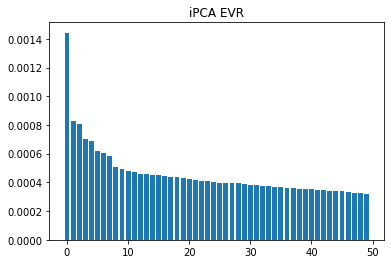

In [8]:
fig = plt.figure(figsize=(6, 4))
plt.bar(np.arange(n_comp), ipca.explained_variance_ratio_)
plt.title('iPCA EVR')
plt.show()

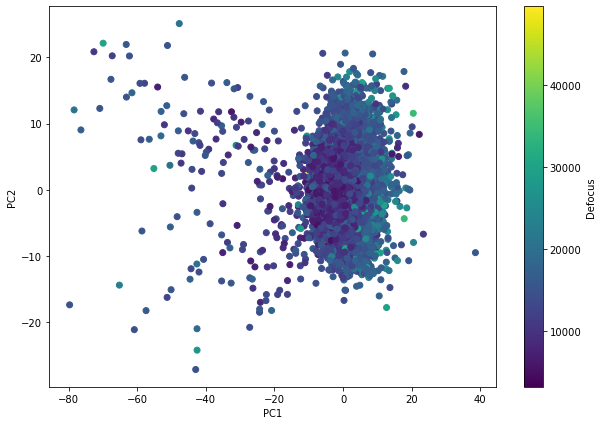

In [9]:
fig = plt.figure(figsize=(10, 7))
pc12 = plt.scatter(coordinates[:, 0], coordinates[:, 1], c=defocus, cmap='viridis')
cbar = plt.colorbar(pc12)
cbar.set_label('Defocus')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

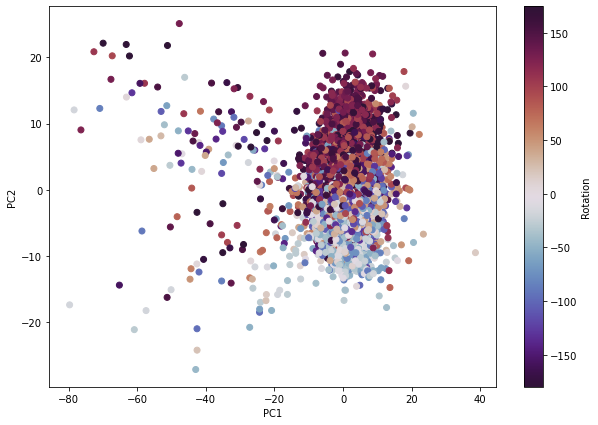

In [10]:
fig = plt.figure(figsize=(10, 7))
pc12 = plt.scatter(coordinates[:, 0], coordinates[:, 1], c=rot, cmap='twilight_shifted')
cbar = plt.colorbar(pc12)
cbar.set_label('Rotation')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [11]:
cplx = np.zeros((n_images, 2))

for i in range(n_images) :
    z = complex(real=coordinates[i, 0], imag=coordinates[i, 1])
    cplx[i] = np.array([np.abs(z), np.angle(z, deg=True)])

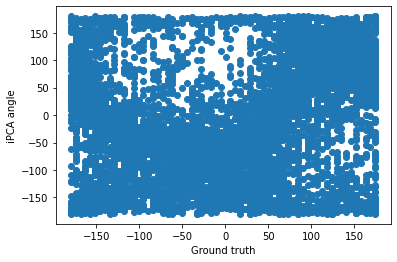

In [12]:
plt.scatter(rot, cplx[:, 1])
plt.xlabel('Ground truth')
plt.ylabel('iPCA angle')
plt.show()

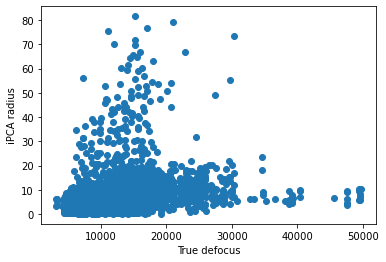

In [13]:
plt.scatter(defocus, cplx[:, 0])
plt.xlabel('True defocus')
plt.ylabel('iPCA radius')
plt.show()